# Sales Performance & Customer Behavior Analysis

This notebook provides an interactive view of the SQL analysis results.
It queries the cleaned sales view from the SQLite database and reproduces
the same insights generated in `03_sales_analysis.sql`.

No data loading or cleaning is performed here.

_Queries below are adapted directly from `sql/03_sales_analysis.sql`._

### Setup and Viewing

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Connect to existing SQLite database
conn = sqlite3.connect("../sales.db")


In [3]:
# verify that clean_sales exists
pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='view';",
    conn
)


,name
0,clean_sales


In [4]:
# load cleaned data for viewing
clean_sales = pd.read_sql(
    "SELECT * FROM clean_sales;",
    conn
)

clean_sales.head()


,InvoiceNo,InvoiceDate,CustomerID,Country,Quantity,UnitPrice,sales_value
0,536365,12/1/2010 8:26,17850,United Kingdom,6,2.55,15.30
1,536365,12/1/2010 8:26,17850,United Kingdom,6,3.39,20.34
2,536365,12/1/2010 8:26,17850,United Kingdom,8,2.75,22.00
3,536365,12/1/2010 8:26,17850,United Kingdom,6,3.39,20.34
4,536365,12/1/2010 8:26,17850,United Kingdom,6,3.39,20.34


### Data Audit

In [5]:
# Data Audit Printout
raw_count = pd.read_sql_query("SELECT COUNT(*) as total FROM sales", conn).iloc[0]['total']
clean_count = pd.read_sql_query("SELECT COUNT(*) as total FROM clean_sales", conn).iloc[0]['total']

print(f"Raw Records Loaded: {raw_count:,}")
print(f"Clean Records for Analysis: {clean_count:,}")
print(f"Filtered out {raw_count - clean_count:,} records (Returns, Null IDs, and Adjustments).")

Raw Records Loaded: 541,909
Clean Records for Analysis: 397,884
Filtered out 144,025 records (Returns, Null IDs, and Adjustments).


## Analysis:

### Core Sales Metrics:

#### Section: Total Revenue & Order Volume

In [6]:
pd.read_sql("""
SELECT
    COUNT(DISTINCT InvoiceNo) AS total_orders,
    printf('%,.2f', SUM(sales_value)) AS total_revenue
FROM clean_sales;
""", conn)


,total_orders,total_revenue
0,18532,"8,911,407.90"


#### Section: Revenue by Country

In [7]:
pd.read_sql("""
SELECT 
  Country,
printf('%,.2f', SUM(sales_value)) AS country_revenue
FROM clean_sales
GROUP BY Country
ORDER BY SUM(sales_value) DESC;
""", conn)

,Country,country_revenue
0,United Kingdom,"7,308,391.55"
1,Netherlands,"285,446.34"
2,EIRE,"265,545.90"
3,Germany,"228,867.14"
4,France,"209,024.05"
5,Australia,"138,521.31"
6,Spain,"61,577.11"
7,Switzerland,"56,443.95"
8,Belgium,"41,196.34"
9,Sweden,"38,378.33"


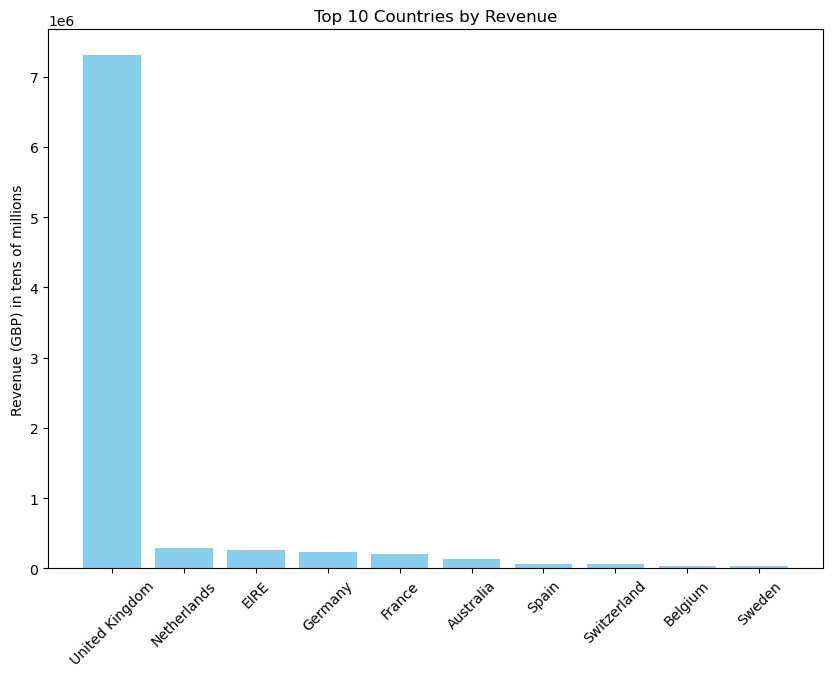

In [8]:
# Pull the SQL data into a dataframe for plotting
country_data = pd.read_sql_query("""
    SELECT Country, SUM(sales_value) as Revenue 
    FROM clean_sales 
    GROUP BY Country 
    ORDER BY SUM(sales_value) DESC 
    LIMIT 10
""", conn)

# Plot top 10 countries by revenue to understand distribution of revenue
plt.figure(figsize=(10, 7))
plt.bar(country_data['Country'], country_data['Revenue'], color='skyblue')
plt.title('Top 10 Countries by Revenue')
plt.xticks(rotation=45)
plt.ylabel('Revenue (GBP) in tens of millions')
plt.show()

### Section: Monthly Revenue Trend

In [9]:
pd.read_sql("""
WITH monthly_data AS (
    SELECT 
      printf('%s-%02d', 
      -- Formats InvoiceDate string to 'YYYY-MM', taking year (last 4 digits before space) and month (before first slash)
        SUBSTR(InvoiceDate, INSTR(InvoiceDate, ' ') - 4, 4), 
        SUBSTR(InvoiceDate, 1, INSTR(InvoiceDate, '/') - 1)
      ) AS month,       -- Example: 'DD/MM/YYYY HH:MI' becomes 'YYYY-MM'
      SUM(sales_value) AS revenue_val
    FROM clean_sales
    GROUP BY month
)
-- Monthly Rows
SELECT month, printf('%,.2f', revenue_val) AS monthly_revenue
FROM monthly_data

UNION ALL

-- Check to ensure Grand Total matches total revenue across all transactions
SELECT 'GRAND TOTAL', printf('%,.2f', SUM(revenue_val))
FROM monthly_data;
""", conn)

,month,monthly_revenue
0,2010-12,"572,713.89"
1,2011-01,"569,445.04"
2,2011-02,"447,137.35"
3,2011-03,"595,500.76"
4,2011-04,"469,200.36"
5,2011-05,"678,594.56"
6,2011-06,"661,213.69"
7,2011-07,"600,091.01"
8,2011-08,"645,343.90"
9,2011-09,"952,838.38"


### CUSTOMER-LEVEL ANALYSIS:

### Section: Top 10 highest-spending customers

In [10]:
pd.read_sql("""
WITH customer_totals AS (
  SELECT
    CustomerID,
    ROUND(SUM(sales_value), 2) AS total_spent
  FROM clean_sales
  GROUP BY CustomerID
)
SELECT *
FROM customer_totals
ORDER BY total_spent DESC
LIMIT 10;
""", conn)

,CustomerID,total_spent
0,14646,280206.02
1,18102,259657.30
2,17450,194550.79
3,16446,168472.50
4,14911,143825.06
5,12415,124914.53
6,14156,117379.63
7,17511,91062.38
8,16029,81024.84
9,12346,77183.60


### Section: Customer Purchase Frequency (repeat customers only)

In [11]:
pd.read_sql("""
SELECT 
  CustomerID,
  COUNT(DISTINCT InvoiceNo) AS total_orders
FROM clean_sales
GROUP BY CustomerID
HAVING total_orders > 1
ORDER BY total_orders DESC
LIMIT 30;
""", conn)

,CustomerID,total_orders
0,12748,209
1,14911,201
2,17841,124
3,13089,97
4,14606,93
5,15311,91
6,12971,86
7,14646,73
8,16029,63
9,13408,62


### Section: Average order value across all customers

In [12]:
pd.read_sql("""
SELECT
  ROUND(
    SUM(sales_value) / COUNT(DISTINCT InvoiceNo),2) AS avg_order_value
FROM clean_sales;
""", conn)

,avg_order_value
0,480.87


### Section: Customer Segments (VIP, High Value, Standard)   

In [13]:
pd.read_sql("""
WITH customer_segments AS (
  SELECT 
    CustomerID,
    SUM(sales_value) AS total_spent,
    CASE 
      WHEN SUM(sales_value) > 5000 THEN 'VIP'
      WHEN SUM(sales_value) > 1000 THEN 'High Value'
      ELSE 'Standard'
    END AS customer_segment
  FROM clean_sales
  GROUP BY CustomerID
)

SELECT 
  customer_segment,
  COUNT(*) AS customer_count
FROM customer_segments
GROUP BY customer_segment
ORDER BY customer_count DESC;
""", conn)

,customer_segment,customer_count
0,Standard,2670
1,High Value,1393
2,VIP,275


### BASIC WINDOW FUNCTION ANALYSIS

### Percentage contribution of each country to total revenue

In [14]:
pd.read_sql("""
SELECT
  Country,
  ROUND(SUM(sales_value), 2) AS country_revenue,
  ROUND(
    SUM(sales_value) * 100.0 /
    SUM(SUM(sales_value)) OVER (),
    2
  ) AS percentage_of_total_revenue
FROM clean_sales
GROUP BY Country
ORDER BY country_revenue DESC;
""", conn)

,Country,country_revenue,percentage_of_total_revenue
0,United Kingdom,7308391.55,82.01
1,Netherlands,285446.34,3.20
2,EIRE,265545.90,2.98
3,Germany,228867.14,2.57
4,France,209024.05,2.35
5,Australia,138521.31,1.55
6,Spain,61577.11,0.69
7,Switzerland,56443.95,0.63
8,Belgium,41196.34,0.46
9,Sweden,38378.33,0.43


### Section: Compare individual customer order counts to the average

In [15]:
pd.read_sql("""
WITH customer_counts AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS total_orders
  FROM clean_sales
  GROUP BY CustomerID
)
SELECT
  CustomerID,
  total_orders,
  ROUND(AVG(total_orders) OVER (), 2) AS avg_orders_per_customer,
  ROUND(total_orders - AVG(total_orders) OVER (), 2) AS variance_from_avg
FROM customer_counts
ORDER BY total_orders DESC
LIMIT 70;
""", conn)

,CustomerID,total_orders,avg_orders_per_customer,variance_from_avg
0,12748,209,4.27,204.73
1,14911,201,4.27,196.73
2,17841,124,4.27,119.73
3,13089,97,4.27,92.73
4,14606,93,4.27,88.73
...,...,...,...,...
65,13534,25,4.27,20.73
66,13854,25,4.27,20.73
67,14180,25,4.27,20.73
68,14667,25,4.27,20.73


### Join Based Analysis

### Transaction details for high-value customers


In [16]:
pd.read_sql("""
WITH customer_totals AS (
  SELECT
    CustomerID,
    SUM(sales_value) AS total_spent
  FROM clean_sales
  GROUP BY CustomerID
)
  SELECT
    cs.InvoiceNo,
    cs.InvoiceDate,
    cs.CustomerID,
    ROUND(cs.sales_value, 2) AS transaction_value,
    ROUND(ct.total_spent, 2) AS lifetime_spent
  FROM clean_sales cs
  JOIN customer_totals ct
    ON cs.CustomerID = ct.CustomerID
  ORDER BY ct.total_spent DESC
  LIMIT 20;
""", conn)

,InvoiceNo,InvoiceDate,CustomerID,transaction_value,lifetime_spent
0,539491,12/20/2010 10:09,14646,3.48,280206.02
1,539491,12/20/2010 10:09,14646,3.48,280206.02
2,539491,12/20/2010 10:09,14646,9.90,280206.02
3,539491,12/20/2010 10:09,14646,1.95,280206.02
4,539491,12/20/2010 10:09,14646,1.70,280206.02
5,539491,12/20/2010 10:09,14646,2.10,280206.02
6,539491,12/20/2010 10:09,14646,9.90,280206.02
7,539491,12/20/2010 10:09,14646,4.25,280206.02
8,539491,12/20/2010 10:09,14646,1.70,280206.02
9,539491,12/20/2010 10:09,14646,2.50,280206.02


### Compare highest individual order values to total revenue of the customer's country

In [17]:
pd.read_sql("""
WITH country_revenue AS (
  SELECT
    Country,
    SUM(sales_value) AS total_country_revenue
  FROM clean_sales
  GROUP BY Country
)
SELECT
  cs.InvoiceNo,
  cs.Country,
  ROUND(cs.sales_value, 2) AS order_value,
  ROUND(cr.total_country_revenue, 2) AS country_revenue
FROM clean_sales cs
JOIN country_revenue cr
  ON cs.Country = cr.Country
ORDER BY order_value DESC
LIMIT 20;
""", conn)

,InvoiceNo,Country,order_value,country_revenue
0,581483,United Kingdom,168469.60,7308391.55
1,541431,United Kingdom,77183.60,7308391.55
2,556444,United Kingdom,38970.00,7308391.55
3,551697,United Kingdom,8142.75,7308391.55
4,567423,United Kingdom,7144.72,7308391.55
5,540815,United Kingdom,6539.40,7308391.55
6,550461,United Kingdom,6539.40,7308391.55
7,573003,Netherlands,4992.00,285446.34
8,540815,United Kingdom,4921.50,7308391.55
9,550461,United Kingdom,4632.00,7308391.55


In [18]:
pd.read_sql("""
SELECT COUNT(*) FROM sales;
""", conn)

,COUNT(*)
0,541909


In [19]:
pd.read_sql("""
SELECT COUNT(*) FROM clean_sales;
""", conn)

,COUNT(*)
0,397884


## Key Insights
- Total revenue during the analysis period was approximately __£8.9M__.
- Sales are highly concentrated in the UK, accounting  for __~82%__ of total revenue.
- Revenue peaks in __November 2011__, indicating strong seasonal purchasing behavior heading into the holidays. 
- __Customer Skew:__ while the average customer places ~4 orders, a small subset of users place over 200 orders, which contributes to a disproportionate share of revenue.
- __Retention Opportunity:__ Only __38%__ of customers fall into the VIP/High-Value segments, yet they account for a significant portion of total revenue, this signals a major opportunity to optimize growth through specialized VIP retention strategies.